# PROJECT: Course Optimization for Data Science 2021-2022
## Optimization strategies for the multiclass multinomial logistic regression with non-smooth penalties


Author: Alexandre Gramfort

If you have questions or if something is not clear in the text below please contact us
by email.

## Aim:

- Derive mathematically and implement the loss and gradients of the multinomial logistic regression model
- Implement your own solvers for L1, L2 and L1/L2 regularizations with: (Accelerated) Proximal gradient descent, proximal coordinate descent and L-BFGS (only for L2)
- Implement your own scikit-learn estimator for the multinomial logistic regression model and test it on the `digits` dataset.


## VERY IMPORTANT

This work must be done by pairs of students.
Each student must send their work before the 4th of March 2022 at 23:59, using the moodle platform.
This means that **each student in the pair sends the same file**

On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called "Project".
This is where you submit your jupyter notebook file.

The name of the file must be constructed as in the next cell

### Gentle reminder: no evaluation if you don't respect this EXACTLY

#### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "guillaume"
ln1 = "peltier"
fn2 = "nhat-minh"
ln2 = "dao"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["project", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

project_peltier_guillaume_and_dao_nhat-minh.ipynb


Some imports

In [2]:
%matplotlib inline
import numpy as np
from scipy import linalg
import time
import matplotlib.pyplot as plt
from scipy.optimize import minimize

## Part 0: Multinomial logistic regression model

This model is a multinomial logistic regression model. It is a supervised learning model, in the case where the target space $\mathcal{Y}$ is discrete: $\mathcal{Y}=\{1, \dots, K\}$; this is a multiclass classification model.

We consider a sample $x \in \mathbb{R}^{P}$ belonging to $K$ possible classes.

We want to solve the classification task, _i.e.,_ learn the parameters $\theta = (\mathbf{W}, \mathbf{b}) \in \mathbb{R}^{P\times K}\times \mathbb{R}^{K}$ of the function $f_\theta: \mathbb{R}^P \to [0, 1]^K$ which corresponds for each coordinate to the probability of being from one class.

The model is defined as
$$
[f_\theta(x)]_k = \mathbb{P}[Y=k | x] = \frac{1}{Z} \exp(w_k^\top x + b_k) \enspace ,
$$
where $w_k$ corresponds to the kth column of $W$, and $Z$ is a normalizing constant.

As these probabilities must sum to one, we get
$$
Z = \sum_{k=1}^K \exp(w_k^\top x + b_k).
$$
We can recognize the so-called _soft-max_ function: $[\sigma(z)]_i = \frac{e^{z_i}}{\sum_{k=1}^K e^{z_k}}$.

After one-hot encoding of the target variable ([`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), denoting $\{ y_{ik} \}_{k=1}^{K}$ the indicator sequence for the class of the $i^{\text{th}}$ observation $x_i$ (i.e., if the sample $i$ belongs to class $k$, then $y_{ik} = 1$ and $y_{ik'}=0$ for $k'\neq k$) the negative log likelihood (**nll**, _a.k.a_ cross-enropy loss) becomes:
$$
L(W, b) = - \frac1N \sum_{i=1}^N \log(\mathbb{P}[Y=y_i | x_i]) = -\frac1N \sum_{i=1}^N \log\Bigg(\frac{\exp(w_{y_i}^\top x_i + b_{y_i})}{\sum_{k=1}^K \exp(w_k^\top x_i+ b_k)}\Bigg) \enspace .
$$

**Note:** The notation $w_{y_i}$ means the column of $W$ whose index corresponds to the class value (e.g. 1, 2, ..., K) for the sample $x_i$.

Using the softmax function, we can also rewrite this as
$$
L(W, b) =  -\frac1N \sum_{i=1}^N \log([\sigma(Wx_i + b)]_{y_i})
$$

Introducing some regularization on the parameter $W$ with parameter $\lambda \ge 0$, the penalized likelihood estimation problem is written:

$$
    (\mathcal{P}):
\min_{W, b} \quad L(W, b) + \lambda \mathcal{R}(W)
$$

where $\mathcal{R}(W)$ can be :
- $\mathcal{R}_1(W) = \|W\|_1 = \sum_{j=1}^P \sum_k^K |W_{jk}|$, ie. an $\ell_1$ norm
- $\mathcal{R}_2(W) = \tfrac{1}{2} \|W\|^2_F = \tfrac{1}{2} \sum_{j=1}^P \sum_{k=1}^K W_{jk}^2$, ie. a squared $\ell_2$ norm 
- $\mathcal{R}_{21}(W) = \|W\|_{21} = \sum_{j=1}^P \sqrt{\sum_{k=1}^K W_{jk}^2}$, ie. an $\ell_{21}$ mixed-norm. This corresponds to the $\ell_1$ norm of the sequence of $\ell_2$ norms of the rows of $W$.

<div class="alert alert-success">
    <b>QUESTION 1:</b>
     <ul>
      <li>Justify that $(\mathcal{P})$ is a convex problem for the 3 different choices of regularization.</li>
    </ul>
</div>

**Hint**: You can show that for $z\in\mathbb{R}^K$ and $1\leq j\leq K$, the function $z\to -\log(\sigma(z)_j)$ is convex.

**L is convex**


$\forall i \in \{1,...,N\}$, we have that $ -\log\Bigg(\frac{\exp(w_{y_i}^\top x_i + b_{y_i})}{\sum_{k=1}^K \exp(w_k^\top x_i+ b_k)}\Bigg) = -( w_{y_i}^\top x_i + b_{y_i}) + \log\Bigg({\sum_{k=1}^K \exp(w_k^\top x_i+ b_k)}\Bigg)$

Then $W,b \longrightarrow  \log\Bigg(\frac{\exp(w_{y_i}^\top x_i + b_{y_i})}{\sum_{k=1}^K \exp(w_k^\top x_i+ b_k)}\Bigg)$ is a convex function as a sum of a linear term in $W,b$ and a convex term (Log-sum-exp being convex in $W,b$). 

$L(W,b)$ is then a convex function as a positive weighted sum of convex functions.

**All p-norms are convexe**

\begin{aligned}
\left\|t x_{1}+(1-t) x_{2}\right\| & \leq\left\|t x_{1}\right\|+\left\|(1-t) x_{2}\right\| \text { (Triangle Inequality) } \\
&=t\left\|x_{1}\right\|+(1-t)\left\|x_{2}\right\| \text { (Homogeniety) }
\end{aligned}

$L(W, b) + \lambda \mathcal{R}_1(W)$

As a sum of convex fonctions ($L$ and a norm) is convex, this problem is convex.

$L(W, b) + \lambda \mathcal{R}_2(W)$

As a norm $\|W\|_2$ is convex and non negative then its square is convex. Then as a  sum of convex functions, this problem is convex 

##### $L(W, b) + \lambda \mathcal{R}_{21}(W)$

As a sum of convex fonctions ($L$ and a norm) is convex, this problem is convex.

## Simulation

Let's first generate data under the above model, with $K=3$ classes.

In [3]:
from sklearn.preprocessing import OneHotEncoder

def plot_data(X, y, U=None, ax=None):
    if y.ndim == 1:
        y = OneHotEncoder().fit_transform(y[:, None]).toarray()
    n_classes = y.shape[1]
    class_colors = plt.get_cmap('viridis', n_classes)(range(n_classes))
    # Display the result in ax, which is created if it does not exist.
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 7))
    ax.scatter(X[:, 0], X[:, 1], c=y @ class_colors)

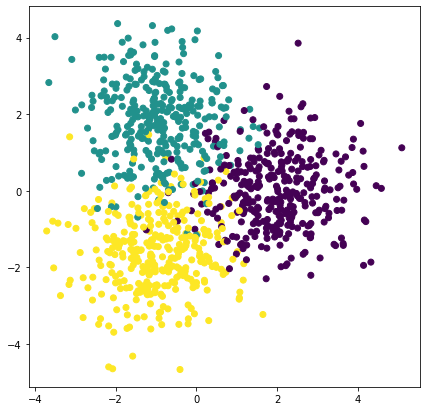

In [4]:
from sklearn.datasets import make_blobs

MU1 = (2, 0)
MU2 = (-1, np.sqrt(3))
MU3 = (-1, -np.sqrt(3))

centers = [MU1, MU2, MU3]
K = len(centers)  # number of classes
N = 1000

X, y_true = make_blobs(N, centers=centers, random_state=42)

plot_data(X, y_true)

In [5]:
# One-hot encoded target
Y = OneHotEncoder().fit_transform(y_true[:, None]).toarray()
Y

array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

Given some random values for $W$ and $b$, we want to compute the quantity $P(Y = k \mid x_i)$ for $k= 1, \dots , K$, and $i= 1, \dots, n$.

Note that in order to predict the label of $x$, we take the arg-maximum of the softmax values.

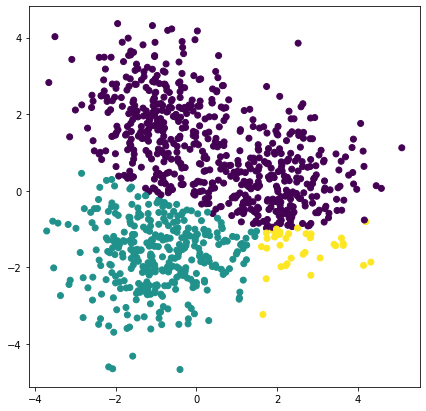

In [6]:
from scipy.special import softmax

rng = np.random.RandomState(42)
P = 2
W = rng.randn(P, K)
b = rng.randn(K)
y_proba_ = softmax(X @ W + b, axis=1)
y_ = np.argmax(y_proba_, axis=1)

plot_data(X, y_)

Note, that the sum of all probabilites for each sample is 1:

In [7]:
np.testing.assert_allclose(np.sum(y_proba_, axis=1), np.ones(N))

# Log-Likelihood function

Following the parametrization from $(\mathcal{P})$, one has `K + K*P` parameters.
We denote the stacked vector of all parameters `params`. The first `K` entries in `params` are the b and the last `K*P` entries correspond to $W$. The function that predicts the probabilities of each sample reads:

In [8]:
def predict_proba(params, X=X):
    """Compute the probability of each sample in X.
    
    Parameters:
    -----------
    params: array, shape (K + K * P,)
        Parameters of the model. The first K entries are the beta_k,
        the remaining K * P ones are the entries of W.

    X: array, shape (N, P)
        The features.

    Returns
    -------
    proba : ndarray, shape (N, K)
        The proba of belonging to each class for each sample.
    """
    _, P = X.shape
    K = params.size // (1 + P)
    b = params[:K]
    W = params[K:].reshape(P, K)
    return softmax(X @ W + b, axis=1)

The negative log-likelihood then reads:

In [9]:
def negloglik(params, X=X, Y=Y):
    Y_proba = predict_proba(params, X)
    loss = -np.log(Y_proba[Y == 1]).mean()
    return loss

params = np.concatenate([b, W.ravel()])
negloglik(params)

2.138083050969259

<div class="alert alert-warning">
    <b>QUESTION 2:</b>
     <ul>
      <li>Can you apply coordinate descent or proximal gradient descent to $(\mathcal{P})$? Justify your answer with mathematical arguments and theoretical results from the course. No coding yet!</li>
    </ul>
</div>

We can use coordinate descent as the objective function of $(P)$ is convex ? We can use the proximal gradient descent as the objective function is lower semi-continuous and convex ??

<div class="alert alert-success">
    <b>QUESTION 3:</b>
     <ul>
      <li>Propose solutions for the proximal operators for the 2 regularization functions: $\mathcal{R}_1(W)$ and $\mathcal{R}_2(W)$.</li>
    </ul>
</div>

**$\mathcal{R}_1(W)$**

By definition : 

$$prox_{\lambda \| W \|_1}(x) = argmin_{w \in W} \left(\lambda \| w \|_1 + \frac{1}{2} \| w - x\|_2^2 \right)$$

On décompose en 3 cas : 
 
 $w_{ij} > 0$: 
 
 $$\frac{\partial prox_{\lambda \| W \|_1}}{\partial w_{ij}} = \lambda + w_{ij} - x_{ij}$$
 
 donc : $w_{ij} = x_{ij} - \lambda$ et ce si $x_{ij} > \lambda$ pour vérifier $w_{ij} > 0$.
 
 $w_{ij} < 0$: 
 
 $$\frac{\partial prox_{\lambda \| W \|_1}}{\partial w_{ij}} = -\lambda + w_{ij} - x_{ij}$$
 
 donc : $w_{ij} = x_{ij} + \lambda$ et ce si $ x_{ij} < -\lambda$ pour vérifier $w_{ij} < 0$.
 
 $w_{ij} = 0$: 
 
 Le sous-gradient peut prendre toutes les valeurs entre $-1$ et $1$ on donc on a bien une annulation si $x < |\lambda|$
 
 Pour résumer : 
 
 $$prox_{\lambda \| W \|_1}(x) = sign(x) \max(|x| - \lambda, 0)$$

*** 
**$\mathcal{R}_2(W)$**

By definition : 

$$prox_{\lambda \frac{1}{2} \| W \|_2^2}(x) = argmin_{w \in W} \left(\frac{1}{2} \lambda \| w \|_2^2 + \frac{1}{2} \| w - x\|_2^2 \right)$$

As it is convex and differentiable we search the $w$ that nullify the gradient: 

$$
\begin{aligned}
\nabla \left(\lambda \frac{1}{2}\| w \|_2^2 + \frac{1}{2} \| w - x\|_2^2\right) &= \lambda w + w - x \\
                                   &= \left(\lambda + 1\right)w - x
\end{aligned}
$$

So : 

$$prox_{\lambda \frac{1}{2} \| W \|_2^2}(x) = \frac{x}{1 + \lambda}$$ 

<div class="alert alert-warning">
    <b>QUESTION 4:</b>
     <ul>
      <li>Justify that the prox for the regularization function $\mathcal{R}_{21}(W)$ is written:
$$
\mathrm{prox}_{\lambda R_{21}} (W) = Z \in \mathbb{R}^{P \times K} \quad \mathrm{where} \quad Z_{i, :} =\left(1 − \frac{\lambda}{\max(\|W_{i,:}\|_2, \lambda)}\right) W_{i, :}  \enspace .
$$
         </li>
    </ul>
</div>

The notation $W_{i, :} \in \mathbb{R}^K$ stands for the ith row of $W$.

Alternatively, we can write this as

$$
Z_{i, :} = \begin{cases} 0 \text{ if } \|W_{i, :}\|_2\leq \lambda \\
(\|W_{i, :}\|_2 - \lambda)\frac{W_{i, :}}{\|W_{i, :}\|_2} \text{ otherwise}
\end{cases}
$$

**HINT:** This proximal operator is called a block thresholding. You can check that the prox for $\mathcal{R}_{21}(W)$ and $\mathcal{R}_{1}(W)$ match with $K=1$.

$$
\mathrm{prox}_{\lambda \| Z \|_{21}}(W) = argmin_{Z} \left(\lambda \| Z \|_{21} + \frac{1}{2} \| Z - W\|_2^2 \right)
$$

$\| Z_{i,:} \|_2 = 0$

## JE NE SAIS PAS 

$\| Z_{i,:} \|_2 > 0$

$$
\begin{aligned}
\frac{\partial \mathrm{prox}_{\lambda \| Z \|_{21}}}{\partial Z_{i,:}} &= \lambda \frac{ Z_{i,:}}{\| Z_{i,:} \|_2} + Z_{i,:} - W_{i,:} \\
 &= \frac{ Z_{i,:}}{\| Z_{i,:} \|_2}(\lambda + \| Z_{i,:} \|_2) - W_{i,:}
\end{aligned}
$$

To set this to zero we have : 

$$
\begin{cases}
\|Z_{i,:} \|_2 &= \| W_{i,:} \|_2 - \lambda \qquad \qquad \text{with } \| W_{i,:} \|_2 - \lambda > 0\\
\frac{Z_{i,:}}{\| Z_{i,:} \|_2} &= \frac{W_{i,:}}{\| W_{i,:} \|_2}
\end{cases}
$$

so : 

$$ Z_{i,:} = \|Z_{i,:} \|_2 \frac{Z_{i,:}}{\| Z_{i,:} \|_2} = (\|W_{i, :}\|_2 - \lambda)\frac{W_{i, :}}{\|W_{i, :}\|_2} $$

To sum up : 

$$\mathrm{prox}_{\lambda R_{21}} (W) = Z \in \mathbb{R}^{P \times K} \quad \mathrm{where} \quad Z_{i, :} =\left(1 − \frac{\lambda}{\max(\|W_{i,:}\|_2, \lambda)}\right) W_{i, :}  \enspace .$$

<div class="alert alert-success">
    <b>QUESTION 5:</b>
     <ul>
      <li>Implement below the proximal operators for the 3 regularization functions: $\mathcal{R}_1(W)$, $\mathcal{R}_2(W)$ and $\mathcal{R}_{21}(W)$.</li>
    </ul>
</div>

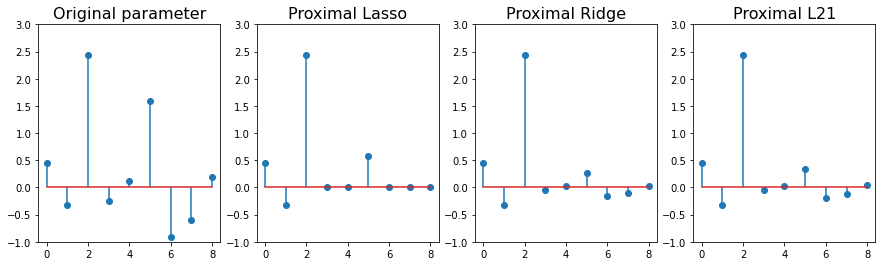

In [10]:
def prox_R2(params, reg=1., K=K):
    """Prox for R2 regularizer"""
    params = params.copy()
    b = params[:K]
    W = params[K:].reshape(-1, K)
    # TODO
    W *= 1/(1 + reg)
    params[K:] = W.flatten()
    # END TODO
    return params


def prox_R1(params, reg=1., K=K):
    """Prox for R1 regularizer"""
    params = params.copy()
    b = params[:K]
    W = params[K:].reshape(-1, K)
    # TODO
    W = np.sign(W) * np.maximum(np.abs(W) - reg, 0.)
    params[K:] = W.flatten()
    # END TODO
    return params


def prox_R21(params, reg=1., K=K):
    """Prox for R21 regularizer"""
    params = params.copy()
    b = params[:K]
    W = params[K:].reshape(-1, K)
    # TODO
    row_norm = np.maximum(np.linalg.norm(W, ord=2), reg)
    W *= (1 - reg/row_norm)
    params[K:] = W.flatten()
    # END TODO
    return params


rng = np.random.RandomState(5)
params = rng.randn((P + 1) * K)
l_l1 = 1.
l_l2 = 5.
l_l21 = 1.3
ylim = [-1, 3]

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 4, 1)
plt.stem(params)
plt.title("Original parameter", fontsize=16)
plt.ylim(ylim)
plt.subplot(1, 4, 2)
plt.stem(prox_R1(params, l_l1))
plt.title("Proximal Lasso", fontsize=16)
plt.ylim(ylim)
plt.subplot(1, 4, 3)
plt.stem(prox_R2(params, l_l2))
plt.title("Proximal Ridge", fontsize=16)
plt.ylim(ylim)
plt.subplot(1, 4, 4)
plt.stem(prox_R21(params, l_l21))
plt.title("Proximal L21", fontsize=16)
plt.ylim(ylim)
plt.show()

**Note:** You see that the proximal operator does not affect the first 3 entries which correspond to the variable `b` which is not regularized.

## Part 1: Implementation of the solvers

### L-BFGS-B Solver

We will start by using the L-BFGS solver provided by `scipy`. To do this you will first propose a mathematical expression for the gradient of the cross-entropy loss (as implement in the `negloglik` function).

<div class="alert alert-success">
    <b>QUESTION 6:</b>
    <ul>
    <li>
        Propose an expression of the gradients of the loss $L(W, b)$ with respect to its two parameters:
        $\nabla_W L(W, b) \in \mathbb{R}^{P \times K}$ and $\nabla_b L(W, b) \in \mathbb{R}^{K}$.
    </li>
    </ul>
</div>

We have: 

$$\nabla_W L(W, b) = [\frac{\partial L}{\partial w_{ji}}]$$

with: 

$$\frac{\partial L}{\partial w_{ji}} = \frac{\partial L}{\partial z_i} \frac{\partial z_i}{\partial w_{ji}}$$

and: 

$$z_i = x_j w_{ji} + b_j$$

so: 

$$
\frac{\partial z_i}{\partial w_{ji}} = x_j
$$

and:

$$\frac{\partial L}{\partial z_{i}} = \frac{\partial L}{\partial \hat{y}_i}\frac{\partial \hat{y}_i}{\partial z_i} + \sum_{t \ne i} \frac{\partial L}{\partial \hat{y}_t}\frac{\partial \hat{y}_t}{\partial z_i} $$

with:

$$\hat{y}_k = \frac{e^{z_k}}{\sum_t e^{z_t}}$$

so we have:

$$\frac{\partial L}{\partial \hat{y}_i} = \frac{\partial}{\partial \hat{y}_i} \left( - \sum_t y_t log \hat{y}_t \right) = - \frac{y_i}{\hat{y}_i}$$

hence: 
$$\frac{\partial L}{\partial z_{i}} = \frac{\partial L}{\partial \hat{y}_i}\frac{\partial \hat{y}_i}{\partial z_i} + \sum_{t \ne i} - \frac{y_t}{\hat{y}_t}\frac{\partial \hat{y}_t}{\partial z_i}$$

The next step is to calculate the other partial derivative terms:

$$
\begin{gathered}
\frac{\partial \hat{y}_{i}}{\partial z_{i}} = 
\frac{\partial}{\partial z_{i}} \frac{e^{z_{i}}}{\sum_{t} e^{z_{t}}} =
\frac{e^{z_{i}} \sum_{t} e^{z_{t}}-e^{z_{i}} e^{z_{i}}}{\left(\sum_{t} e^{z_{t}}\right)^{2}} =
\underbrace{\frac{e^{z_{i}}}{\sum_{t} e^{z_{t}}}}_{\hat{y}_{i}}-\underbrace{\left(\frac{e^{z_{i}}}{\sum_{t} e^{z_{t}}}\right)^{2}}_{\hat{y}_{i}^{2}} =
\hat{y}_{i}-\hat{y}_{i}^{2} \\
\frac{\partial \hat{y}_{t}}{\partial z_{i}} = 
\frac{\partial}{\partial z_{i}} \frac{e^{z_{t}}}{\sum_{u} e^{z_{u}}} = 
\frac{0-e^{z_{t}} e^{z_{i}}}{\left(\sum_{u} e^{z_{u}}\right)^{2}} = 
-\underbrace{\frac{e^{z_{t}}}{\sum_{u} e^{z_{u}}}}_{\hat{y}_{t}} \underbrace{\frac{e^{z_{i}}}{\sum_{u} e^{z_{u}}}}_{\hat{y}_{i}} = 
-\hat{y}_{t} \hat{y}_{i}
\end{gathered}
$$

We replace in the results above:

$$
\begin{aligned}
&\qquad \begin{aligned}
\frac{\partial \mathcal{L}}{\partial z_{i}} &=-\frac{y_{i}}{\hat{y}_{i}} \hat{y}_{i}\left(1-\hat{y}_{i}\right)+\sum_{t \neq i}-\frac{y_{t}}{\hat{y}_{t}}\left(-\hat{y}_{t} \hat{y}_{i}\right)=-y_{i}+y_{i} \hat{y}_{i}+\sum_{t \neq i} y_{t} \hat{y}_{i} \\
&=-y_{i}+\sum_{t} y_{t} \hat{y}_{i}=\hat{y}_{i} \underbrace{\sum_{t} y_{t}}_{=1}-y_{i} = \left(\hat{y}_{i}-y_{i}\right)
\end{aligned}
\end{aligned}
$$
we get the gradient w.r.t $w_{j i}$:
$$
\frac{\partial \mathcal{L}}{\partial w_{j i}}=x_{j}\left(\hat{y}_{i}-y_{i}\right)
$$


For:

$$\nabla_b L(W, b) = [\frac{\partial L}{\partial b_{j}}]$$

It is the same except for:

$$\frac{\partial z_i}{\partial b_{j}} = 1$$

So we get the gradient w.r.t $b_{j}$:
$$
\frac{\partial \mathcal{L}}{\partial b_{j}}=1 * \left(\hat{y}_{i}-y_{i}\right)
$$ 



<div class="alert alert-success">
    <b>QUESTION 7:</b>
    <ul>
    <li>
        Implement the `negloglik_and_grad` function that returns the loss and its gradient.
    </li>
    </ul>
</div>

In [11]:
def negloglik_and_grad(params, X=X, Y=Y):
    """Negative Log-likelihood of the logistic regression model and gradient.

    Parameters
    ----------
    params: array, shape (K + K * P,)
        The parameters.
    X : ndarray, shape (N, P)
        input data.
    Y : ndarray, shape (N, K)
        output targets one-hot encoded.

    Returns
    -------
    loss : float
        log-likelihood of the logreg model
    grad : array, shape (K + K * P,)
        gradient of the model parameters
    """
    K = Y.shape[1]
    P = (params.size // K) - 1
    b = params[:K]
    W = params[K:].reshape(P, K)
    #####################
    # TO DO
    Y_proba = predict_proba(params, X)
    loss = -np.log(Y_proba[Y == 1]).mean()
    
    y_diff = Y_proba - Y
    
    grad_W = np.zeros(W.shape)
    grad_b = np.zeros(b.shape)
    
    for j in range(W.shape[1]):
        grad_b[j] = np.mean((Y_proba - Y)[:,j])
        for i in range(W.shape[0]):
            grad_W[i, j] = np.mean(X[:,i]*(Y_proba - Y)[:,j])
            
    grad = np.concatenate((grad_b, grad_W.flatten()))
    # END TO DO
    #####################
    return loss, grad

You can check your solution with the following code:

In [12]:
from scipy.optimize import check_grad

rng = np.random.RandomState(42)

for _ in range(10):
    x0 = rng.randn((P+1)*K)
    loss1 = negloglik(x0)
    loss2, grad = negloglik_and_grad(x0)
    np.testing.assert_allclose(loss1, loss2)
    grad_error = check_grad(
        lambda x: negloglik_and_grad(x)[0],
        lambda x: negloglik_and_grad(x)[1],
        x0=x0
    )
    assert grad_error < 1e-6

<div class="alert alert-success">
    <b>QUESTION 8:</b>
    <ul>
    <li>
        Solve the optimization using the `fmin_l_bfgs_b` function without any regularization.
    </li>
    </ul>
</div>

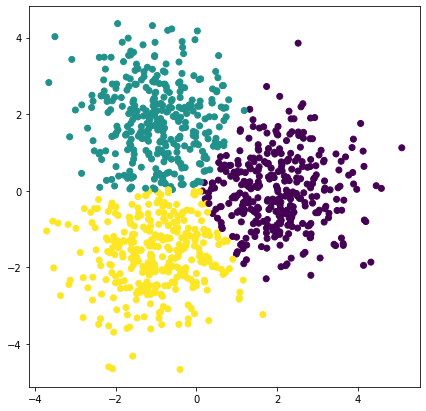

In [13]:
from scipy.optimize import fmin_l_bfgs_b

# TODO
params_hat, _, _ = fmin_l_bfgs_b(lambda x: negloglik_and_grad(x)[0], 
                                 params, 
                                 lambda x: negloglik_and_grad(x)[1])
# END TODO

y_proba = predict_proba(params_hat)
plot_data(X, np.argmax(y_proba, axis=1))

In [14]:
def show_decision_boundary(predict_proba=None, U=None, n_grid=250, ax=None,
                           lim=None, alpha=0.6, data=None):
    """Show decision boundary for predict proba
    """
    if U is None:
        U = np.eye(2)
    assert U.shape[0] == 2

    if lim is None:
        if data is not None:
            X = data[0] @ U
            lim = list(zip(X.min(axis=0), X.max(axis=0)))
        else:
            lim = ((-3, 3), (-3, 3))

    # Compute the probability of each class in the space
    x = np.linspace(*lim[0], n_grid)
    y = np.linspace(*lim[1], n_grid)
    XX, YY = np.meshgrid(x, y[::-1])
    coord = np.array([XX.flatten(), YY.flatten()]).T
    ZZ = predict_proba(X=coord @ U)

    # Compute colors associated to each class
    n_classes = ZZ.shape[1]
    class_colors = plt.get_cmap('viridis', n_classes)(range(n_classes))
    # set alpha to 0.3
    class_colors[:, -1] = alpha
    ZZ = ZZ @ class_colors

    # Display the result in ax, which is created if it does not exist.
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(
        ZZ.reshape(n_grid, n_grid, 4), aspect='auto',
        extent=(*lim[0], *lim[1])
    )

    # If data is provided, plot the scatter plot on top
    if data is not None:
        plot_data(*data, U=U, ax=ax)

    ax.set_xlim(*lim[0])
    ax.set_ylim(*lim[1])

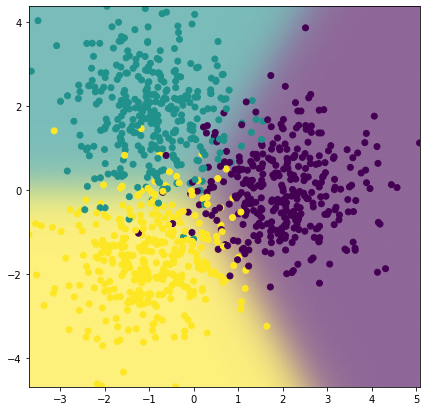

In [15]:
from functools import partial

show_decision_boundary(partial(predict_proba, params=params_hat), data=(X, Y))

<div class="alert alert-warning">
    <b>QUESTION 9:</b>
    <ul>
    <li>
        Wrap this into a function of X, Y and lbda that implements
        the function `multinomial_lbfgs_l2` (Based on $\mathcal{R}_2$ regularization) that will be
        used to get a good value of x_min (minimum of the $\ell_2$ regularized
        model).
    </li>
    </ul>
</div>

To help you we give you the code of the objective to minimize
in case you use $\ell_1$, $\ell_2$ and $\ell_{21}$ penalties.

In [16]:
def pobj_l1(params, X=X, Y=Y, lbda=1.):
    K = Y.shape[1]
    P = (params.size // K) - 1
    W = params[K:].reshape(P, K)
    return negloglik(params, X=X, Y=Y) + lbda * np.sum(np.abs(W))


def pobj_l2(params, X=X, Y=Y, lbda=1.):
    K = Y.shape[1]
    P = (params.size // K) - 1
    W = params[K:].reshape(P, K)
    return negloglik(params, X=X, Y=Y) + lbda / 2 * np.linalg.norm(W, 'fro') ** 2


def pobj_l21(params, X=X, Y=Y, lbda=1.):
    K = Y.shape[1]
    P = (params.size // K) - 1
    W = params[K:].reshape(P, K)
    return negloglik(params, X=X, Y=Y) + lbda * np.linalg.norm(W, axis=1).sum()

In [17]:
def grad_l2(params, X=X, Y=Y, lbda=1.):
    K = Y.shape[1]
    grad = negloglik_and_grad(params, X, Y)[1]
    grad[K:] += lbda * params[K:]
    return grad

In [18]:
def grad_l2(params, X=X, Y=Y, lbda=1.):
    K = Y.shape[1]
    P = (params.size // K) - 1
    b = params[:K]
    W_flat = params[K:]
    grad_w_l2 = negloglik_and_grad(params, X, Y)[1][K:] + lbda * W_flat
    grad_b = negloglik_and_grad(params, X, Y)[1][:K]
    return np.hstack((grad_b,grad_w_l2))

def negloglik_and_grad_l2(params, X, Y, lbda=1.):
  negloglik = pobj_l2(params, X, Y, lbda)
  grad = grad_l2(params, X, Y, lbda)
  return negloglik, grad

In [19]:
def multinomial_lbfgs_l2(X, Y, lbda=1):
    """Minimize the pobj_l2 function using L-BFGS
    
    Parameters
    ----------
    X : ndarray, shape (N, P)
        input data.
    Y : ndarray, shape (N, K)
        output targets one-hot encoded.
    lbda : float
        The regularization strength.

    Returns
    -------
    params_hat: array, shape (K + K * P,)
        The estimated parameters.
    """
    # TODO
    P = X.shape[1]
    K = Y.shape[1]
    
    params_init = np.zeros(K * (1 + P))
    objectif = lambda x: (pobj_l2(x, X=X, Y=Y, lbda=lbda), 
                          grad_l2(x, X=X, Y=Y, lbda=lbda))

    params_hat, _, _ = fmin_l_bfgs_b(objectif, params_init) 
    # END TODO
    return params_hat

multinomial_lbfgs_l2(X, Y, lbda=0.1)

array([-0.03833061, -0.0117601 ,  0.05009072,  0.89680762, -0.43385535,
       -0.46295228, -0.01243924,  0.75914423, -0.74670498])

Now that we have a gradient of the negative loglikelihood term we can implement other solvers. Namely you are going to implement:

- Proximal Gradient Descent (PGD aka ISTA)
- Accelerated Proximal Gradient Descent (APGD aka FISTA)

Before this we are going to define the `monitor` class previously used in the second lab as well as plotting functions useful to monitor convergence.

**Note:** Below, and following standard optimization notations, we will refer to the parameters of the optimization problem as `x`,  `x_min` and `x_init` for simplicity.

In [20]:
class monitor(object):
    def __init__(self, algo, obj, x_min, args=()):
        self.x_min = x_min
        self.algo = algo
        self.obj = obj
        self.args = args
        if self.x_min is not None:
            self.f_min = obj(x_min, *args)

    def run(self, *algo_args, **algo_kwargs):
        t0 = time.time()
        _, x_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time.time() - t0
        self.x_list = x_list
        if self.x_min is not None:
            self.err = [linalg.norm(x - self.x_min) for x in x_list]
            self.obj = [self.obj(x, *self.args) - self.f_min for x in x_list]
        else:
            self.obj = [self.obj(x, *self.args) for x in x_list]


def plot_epochs(monitors, solvers):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    for monit in monitors:
        ax1.semilogy(monit.obj, lw=2)
        if monit.x_min is not None:
            ax1.set_ylabel("$f(x_k) - f(x^*)$")
        else:
            ax1.set_ylabel("$f(x_k)$")
        ax1.set_xlabel("Epoch")
        ax1.set_title("Objective")

    ax1.legend(solvers)

    for monit in monitors:
        if monit.x_min is not None:
            ax2.semilogy(monit.err, lw=2)
            ax2.set_title("Iterates")
            ax2.set_xlabel("Epoch")
            ax2.set_ylabel("$\|x_k - x^*\|_2$")

    ax2.legend(solvers)


def plot_time(monitors, solvers):
    for monit in monitors:
        objs = monit.obj
        plt.semilogy(np.linspace(0, monit.total_time, len(objs)), objs, lw=2)
        plt.title("Loss")
        plt.xlabel("Timing")
        plt.ylabel("$f(x_k) - f(x^*)$")

    plt.legend(solvers)

<div class="alert alert-success">
    <b>QUESTION 10a:</b>
    <ul>
    <li>
        Implement the proximal gradient descent (PGD) method
    </li>
    </ul>
</div>

The parameter `step` is the size of the gradient step.

In [21]:
def pgd(x_init, grad, prox, n_iter=100, step=1., grad_args=(), prox_args=()):
    """Proximal gradient descent algorithm.
    
    Parameters
    ----------
    x_init : ndarray
        Here the params of shape (K + K*P,)
    grad : callable
        The gradient function.
    prox : callable
        The proximal operator function.
    n_iter : int
        The number of iterations
    step : float
        The step size.
    grad_args : tuple
        Extra parameters to pass to the gradient function
        (eg. X, Y)
    prox_args : tuple
        Extra parameters to pass to the prox function
        (eg. lbda, K)
    
    Returns
    -------
    x_hat : ndarray
        The estimated params.
    x_list : list
        The list of iterates values at each iteration.
    """
    x = x_init.copy()
    x_list = []
    for i in range(n_iter):
        ### TODO
        x = prox(x - grad(x, *grad_args) * step, *prox_args)
        ### END TODO
        x_list.append(x.copy())
    return x, x_list

<div class="alert alert-warning">
    <b>QUESTION 10b:</b>
    <ul>
    <li>
        Using the monitor class and the plot_epochs function, display the convergence.
    </li>
    </ul>
</div>

**Note:** You will have to provide a `step` value, which should be theoretially less than `1 / lipschitz_constant`. You will propose a value for it but you are not expected to provide a mathematical proof, unless you think it's a moral duty to give one...

proof of L : https://beginningwithml.wordpress.com/2019/01/07/2-2-finding-a-good-learning-rate/

$$L = \frac{k-1}{km} \|X\|$$

with:
 - $k$ = number of classes
 - $m$ = number of samples
 - $\|X\|$ = Ecluiden norm of our input data

In [22]:
m = X.shape[0]
step = ((K-1) * np.linalg.norm(X) / (K*m))
step = K * N / (linalg.norm(X)**2 * (K-1))

To help you we give you the proximal operator functions for $\ell_1$, $\ell_2$ and $\ell_{21}$ regularized models.

In [23]:
def prox_l1(params, step, lbda, K):
    return prox_R1(params, reg=step * lbda, K=K)

def prox_l2(params, step, lbda, K):
    return prox_R2(params, reg=step * lbda, K=K)

def prox_l21(params, step, lbda, K):
    return prox_R21(params, reg=step * lbda, K=K)

Let's first consider the $\ell_2$ case. You will use the `multinomial_lbfgs_l2` function to obtain a value for `x_min` so that you can display the convergence error on the iterates (ie. $\|x_k - x^*\|$). You will need to pass this `x_min` to the `monitor` function.

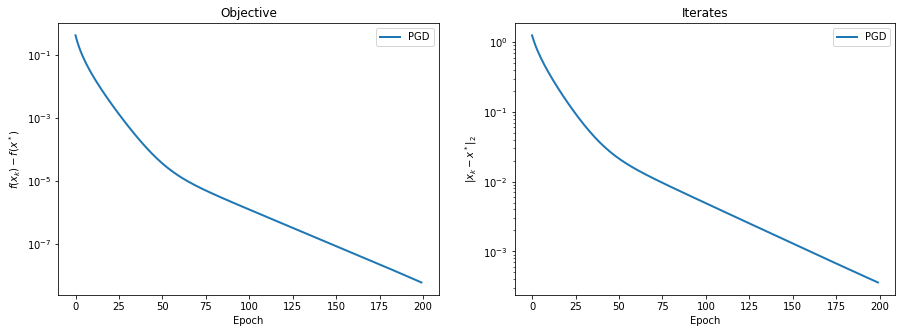

In [24]:
x_init = np.zeros((P + 1) * K)
n_iter = 200
lbda = .1

# TODO
x_min = multinomial_lbfgs_l2(X, Y, lbda)

loss = lambda x: pobj_l2(x, X, Y, lbda)
prox = lambda x: prox_l2(x, step, lbda, K)
grad = lambda params: negloglik_and_grad(params, X, Y)[1]

monitor_pgd_l2 = monitor(pgd, loss, x_min)
monitor_pgd_l2.run(x_init, grad, prox, n_iter, step)
# END TODO

monitors = [monitor_pgd_l2]
solvers = ["PGD"]
plot_epochs(monitors, solvers)

Now for the $\ell_1$ regularization:

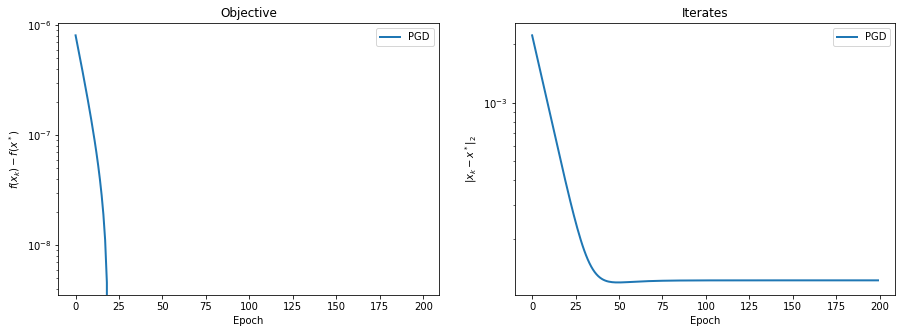

In [25]:
lbda = 1.

# TODO
x_min = minimize(pobj_l1, x_init, args=(X, Y, lbda), method='SLSQP', 
                 options={'ftol':1e-30}).x

loss = lambda x: pobj_l1(x, X, Y, lbda)
prox = lambda x: prox_l1(x, step, lbda, K)
grad = lambda params: negloglik_and_grad(params, X, Y)[1]

monitor_pgd_l1 = monitor(pgd, loss, x_min)
monitor_pgd_l1.run(x_init, grad, prox, n_iter, step)
# END TODO

monitors = [monitor_pgd_l1]
solvers = ["PGD"]
plot_epochs(monitors, solvers)

Now for the $\ell_{21}$ regularization:

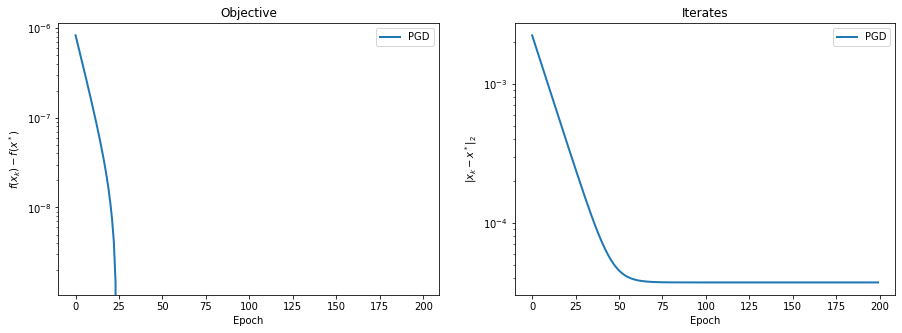

In [26]:
lbda = 1.

# TODO
x_min = minimize(pobj_l21, x_init, args=(X, Y, lbda), method='SLSQP',
                options={'ftol':1e-30}).x

loss = lambda x: pobj_l21(x, X, Y, lbda)
prox = lambda x: prox_l21(x, step, lbda, K)
grad = lambda params: negloglik_and_grad(params, X, Y)[1]

monitor_pgd_l21 = monitor(pgd, loss, x_min) 
monitor_pgd_l21.run(x_init, grad, prox, n_iter, step)
# END TODO

monitors = [monitor_pgd_l21]
solvers = ["PGD"]
plot_epochs(monitors, solvers)

<div class="alert alert-warning">
    <b>QUESTION 11:</b>
    <ul>
    <li>
        Implement the accelerated proximal gradient descent (APGD) and add this solver to the monitoring plots.
    </li>
    </ul>
</div>

In [27]:
def apgd(x_init, grad, prox, n_iter=100, step=1., grad_args=(), prox_args=()):
    """Accelerated proximal gradient descent algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.
    x_list = []
    for i in range(n_iter):
        ### TODO
        x_p1 = prox(y - step*grad(y))
        t_p1 = 0.5 * (1 + np.sqrt(1 + 4 * np.square(t)))
        y = x_p1 + ((t - 1) * (x_p1 - x))/t_p1
        
        x, t = x_p1, t_p1
        ### END TODO
        x_list.append(x.copy())
    return x, x_list

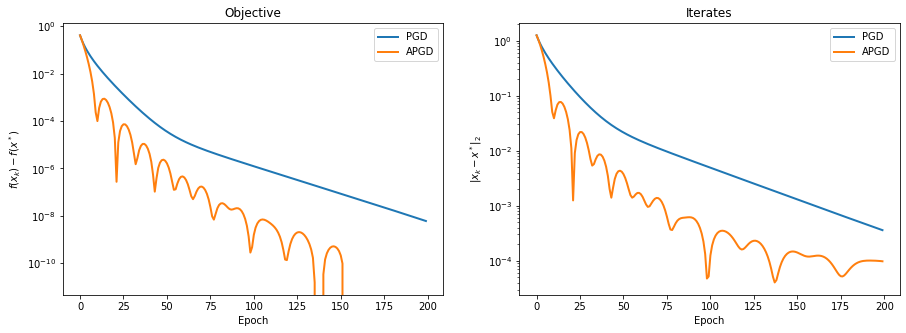

In [28]:
lbda = 0.1

# TODO
x_min = multinomial_lbfgs_l2(X, Y, lbda)

loss = lambda x: pobj_l2(x, X, Y, lbda)
prox = lambda x: prox_l2(x, step, lbda, K)
grad = lambda params: negloglik_and_grad(params, X, Y)[1]

monitor_apgd_l2 = monitor(apgd, loss, x_min)
monitor_apgd_l2.run(x_init, grad, prox, n_iter, step)
# END TODO

monitors = [monitor_pgd_l2, monitor_apgd_l2]
solvers = ["PGD", "APGD"]
plot_epochs(monitors, solvers)

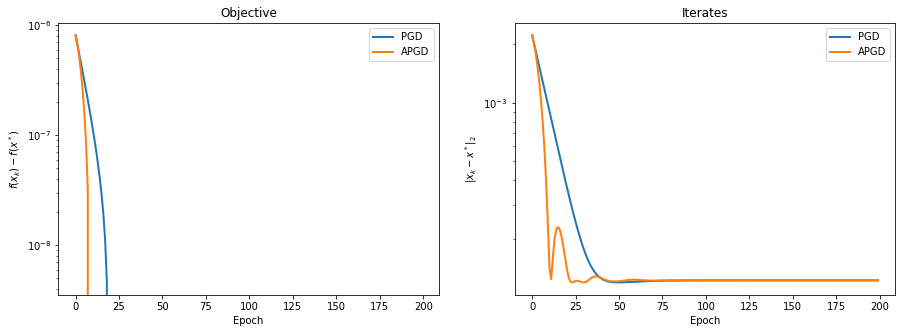

In [29]:
lbda = 1.

# TODO
x_min = minimize(pobj_l1, x_init, args=(X, Y, lbda), method='SLSQP', 
                 options={'ftol':1e-30}).x

loss = lambda x: pobj_l1(x, X, Y, lbda)
prox = lambda x: prox_l1(x, step, lbda, K)
grad = lambda params: negloglik_and_grad(params, X, Y)[1]

monitor_apgd_l1 = monitor(apgd, loss, x_min)
monitor_apgd_l1.run(x_init, grad, prox, n_iter, step)
# END TODO

monitors = [monitor_pgd_l1, monitor_apgd_l1]
solvers = ["PGD", "APGD"]
plot_epochs(monitors, solvers)

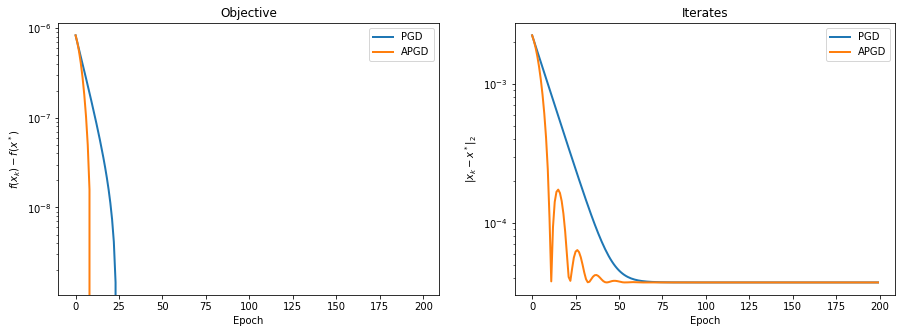

In [30]:
lbda = 1.

# TODO
x_min = minimize(pobj_l21, x_init, args=(X, Y, lbda), method='SLSQP',
                options={'ftol':1e-30}).x

loss = lambda x: pobj_l21(x, X, Y, lbda)
prox = lambda x: prox_l21(x, step, lbda, K)
grad = lambda params: negloglik_and_grad(params, X, Y)[1]

monitor_apgd_l21 = monitor(apgd, loss, x_min) 
monitor_apgd_l21.run(x_init, grad, prox, n_iter, step)
# END TODO

monitors = [monitor_pgd_l21, monitor_apgd_l21]
solvers = ["PGD", "APGD"]
plot_epochs(monitors, solvers)

# Part 2: Application

You will now apply your solver to the `digits` dataset from scikit-learn

Let's first inspect the dataset:

In [31]:
from sklearn.datasets import load_digits
X_digits, y_digits = load_digits(return_X_y=True)
X_digits.shape, y_digits.shape, np.unique(y_digits)

((1797, 64), (1797,), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

Each row of X is an 8x8 image of digit:

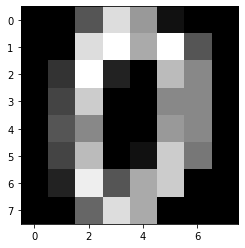

In [32]:
img = X_digits[0].reshape(8, 8)
plt.imshow(img, cmap="gray");

In order to highlight the importance of regularization and especially L1 we are going
to artificially add some random features with pure noise.

In [33]:
X = np.concatenate([X_digits, np.random.randn(len(X_digits), 1000)], axis=1)

Let's do a basic scaling of the features:

In [34]:
from sklearn.preprocessing import scale
X = scale(X)

Now test the functions above with this dataset:

In [35]:
x_init = np.zeros((X.shape[1] + 1) * np.unique(y_digits).size)
Y = OneHotEncoder().fit_transform(y_digits[:, None]).toarray()
print(negloglik(x_init, X=X, Y=Y))
print(negloglik_and_grad(x_init, X=X, Y=Y)[1].shape)

2.3025850929940463
(10650,)


In order to facilitate our experiment we're going to write a full scikit-learn estimator.

<div class="alert alert-warning">
    <b>QUESTION 12:</b>
    <ul>
    <li>
        Implement the `fit` method from the estimator in the next cell
    </li>
    </ul>
</div>

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin


class MultinomialLogistic(BaseEstimator, ClassifierMixin):
    """scikit-learn estimator for the MultinomialLogistic model
    
    Parameters
    ----------
    lbda : float
        The regularization parameter
    penalty : 'l1' | 'l2' | 'l21'
        The type of regularization to use.
    max_iter : int
        The number of iterations / epochs to do on the data.
    solver : 'pgd' | 'apgd' | 'lbfgs'
        The type of regularization to use.
        'lbfgs' is only supported with penalty='l2'.
        
    Attributes
    ----------
    W_ : ndarray, shape (n_features, n_classes)
        The weights.
    b_ : ndarray, shape (n_classes,)
        The biases / intercepts.
    """
    def __init__(self, lbda=1., penalty='l2', max_iter=2000,
                 solver='lbfgs'):
        self.lbda = lbda
        self.penalty = penalty
        self.max_iter = max_iter
        self.solver = solver
        assert self.penalty in ['l1', 'l2', 'l21']
        assert self.solver in ['pgd', 'apgd', 'lbfgs'] 

    def fit(self, X, y):
        """Fit method
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.
        y : ndarray, shape (n_samples,)
            The target. Must be integers between 0 and n_classes - 1.
        """
        n_classes = int(np.max(y)) + 1
        assert np.all(np.unique(y) == np.arange(n_classes))
        Y = OneHotEncoder().fit_transform(y[:, None]).toarray()
        n_samples, n_features = X.shape
        # TODO
        x_init = np.ones((n_features + 1)*n_classes)
        step = (n_classes-1) * np.linalg.norm(X) / (n_classes*n_features)
        
        if self.solver == 'lbfgs':
            x = multinomial_lbfgs_l2(X, Y, self.lbda)
        else:
            all_prox = {'l1': prox_l1,
                        'l2': prox_l2,
                        'l21': prox_l21}
            all_solver = {'pgd': pgd,
                          'apgd': apgd}
            
            prox = lambda x: all_prox[self.penalty](x, step, 
                                                    self.lbda, n_classes)
            grad = lambda params: negloglik_and_grad(params, X, Y)[1]
            solver = all_solver[self.solver]
            
            x = solver(x_init, grad, prox, self.max_iter, step)[0]

        b = x[:n_classes]
        W = x[n_classes:].reshape(n_features, n_classes)
        # END TODO
        self.params_ = x
        self.W_ = W
        self.b_ = b
        return self

    def predict(self, X):
        """Predict method
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.

        Returns
        -------
        y_pred : ndarray, shape (n_samples,)
            The predicted target.
        """
        return np.argmax(self.predict_proba(X), axis=1)

    def predict_proba(self, X):
        """Predict proba method
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.

        Returns
        -------
        y_proba : ndarray, shape (n_samples, n_classes)
            The predicted probabilities.
        """
        return predict_proba(self.params_, X)


for solver in ['pgd', 'apgd', 'lbfgs']:
    clf = MultinomialLogistic(lbda=1., penalty='l2', max_iter=1000, solver=solver)
    clf.fit(X, y_digits)
    print('Solver with L2: %s   -   Score : %s' % (solver, clf.score(X, y_digits)))

for solver in ['pgd', 'apgd']:
    clf = MultinomialLogistic(lbda=.01, penalty='l1', max_iter=1000, solver=solver)
    clf.fit(X, y_digits)
    print('Solver with L1: %s   -   Score : %s' % (solver, clf.score(X, y_digits)))
    
for solver in ['pgd', 'apgd']:
    clf = MultinomialLogistic(lbda=.01, penalty='l21', max_iter=1000, solver=solver)
    clf.fit(X, y_digits)
    print('Solver with L21: %s   -   Score : %s' % (solver, clf.score(X, y_digits)))

Solver with L2: pgd   -   Score : 0.9799666110183639


<div class="alert alert-danger">
    <b>QUESTION 13:</b>
    <ul>
    <li>
        Compare the performance of your model on test data when varying
        the penalty among $\ell_2$, $\ell_1$ and $\ell_{21}$ for a grid of lambda values. Comment on what you see on the curves.
    </li>
    </ul>
</div>

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_digits, random_state=42)
lbda_grid = np.geomspace(1e-4, 1e2, 8)

# TODO

# END TODO

INSERT YOUR ANSWER HERE

# Part 3 (bonus): Implement block-coordinate descent

<div class="alert alert-danger">
    <b>QUESTION 14:</b>
    <ul>
    <li>
        Implement a proximal block-coordinate descent algorithm and add this solver to the monitoring plots.
    </li>
    </ul>
</div>

**HINT:** The easiest way is to use block udpates where you update iteratively for each pass over the data first `b` and then each row of `W`.

In [ ]:
### TODO

### END TODO